In [1]:
import glob
import warnings
import os
import random
import logging

from PIL import Image

import numpy as np

from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D, RepeatVector, Reshape, Flatten, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils.data_utils import get_file

from scipy.misc import imsave

from deeplab import BilinearUpsampling, SepConv_BN, _xception_block, _conv2d_same

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def compose(*layers, **kwargs):
    out = layers[0]
    for layer in layers[1:]:
        try:
            out = layer(out)
        except:
            logging.error("Error with %s", layer.name)
            raise
    return Model(layers[0], out, **kwargs)

In [3]:
def imread(fname):
    im = Image.open(fname)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    if im.size != (128, 128):
        print('Resizing', fname)
        im = im.resize((128, 128), Image.BILINEAR)
    return np.asarray(im) / 255.

In [4]:
from keras.callbacks import Callback

class ShowSample(Callback):

    def __init__(self, period=1):
        self.period = period

    def on_epoch_end(self, epoch, logs):
        if epoch % self.period == self.period - 1:
            self.draw()

    def on_train_end(self, logs):
        if len(logs) % self.period != self.period - 1:
            self.draw()
            
    def draw(self):
        v1 = [V1[i][0] for i in np.random.choice(np.arange(len(V1)), 3)]
        v2 = [V2[i][0] for i in np.random.choice(np.arange(len(V2)), 3)]
        orig_imgs = np.concatenate(np.expand_dims(v2 + v1, 0))
        pred = self.model.predict([orig_imgs, np.array([1] * len(v2) + [0] * len(v1))])
        pred_inv = self.model.predict([orig_imgs, np.array([0] * len(v2) + [1] * len(v1))])
        n_cols = 9
        n_rows = int(len(pred) / (n_cols / 3) + .5)
        plt.figure(figsize=(128 * n_cols / 96 * 2, 128 * n_rows / 96 * 2))
        for n, (a, b, c) in enumerate(zip(orig_imgs, pred, pred_inv)):
            plt.subplot(n_rows, n_cols, n * 3 + 1)
            plt.axis('off')
            plt.imshow(a.reshape(128, 128, 3))
            plt.subplot(n_rows, n_cols, n * 3 + 2)
            plt.axis('off')
            plt.imshow(b.reshape(128, 128, 3)) # * np.linalg.norm(i))
            plt.subplot(n_rows, n_cols, n * 3 + 3)
            plt.axis('off')
            plt.imshow(c.reshape(128, 128, 3)) # * np.linalg.norm(i))
        plt.show()

In [5]:
X1 = [(imread(i), 0) for i in glob.glob('c1/*.jpg')]
X2 = [(imread(i), 1) for i in glob.glob('c2/*.jpg')]

X = X1 + X2
random.shuffle(X)

Resizing c2/image0004008.jpg
Resizing c2/image0011604.jpg
Resizing c2/image0003448.jpg


In [6]:
X = [np.concatenate([np.expand_dims(i[0], 0) for i in X]),
     np.concatenate([np.expand_dims(i[1], 0) for i in X])]
y = X[0]

input_shape = X[0][0].shape

In [7]:
image_input = Input(shape=input_shape, name='image_input')
label_input = Input(shape=(1,), name='label_input')

label_2d = Reshape((128, 128, 1))(RepeatVector(128 * 128)(label_input))
encoder_input = concat([image_input, label_2d])

entry_block3_stride = 2
middle_block_rate = 1
exit_block_rates = (1, 2)
atrous_rates = (6, 12, 18)
OS = 16

x = Conv2D(32, (3, 3), strides=(2, 2),
           name='entry_flow_conv1_1', use_bias=False, padding='same')(encoder_input)
x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
x = Activation('relu')(x)

x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
x = Activation('relu')(x)

x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                    skip_connection_type='conv', stride=2,
                    depth_activation=False)
x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                           skip_connection_type='conv', stride=2,
                           depth_activation=False, return_skip=True)

x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                    skip_connection_type='conv', stride=entry_block3_stride,
                    depth_activation=False)
for i in range(16):
    x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                        skip_connection_type='sum', stride=1, rate=middle_block_rate,
                        depth_activation=False)

x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                    skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                    depth_activation=False)
x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                    skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                    depth_activation=True)

# end of feature extractor

# branching for Atrous Spatial Pyramid Pooling

# Image Feature branch
#out_shape = int(np.ceil(input_shape[0] / OS))
b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
b4 = Conv2D(256, (1, 1), padding='same',
            use_bias=False, name='image_pooling')(b4)
b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
b4 = Activation('relu')(b4)
b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

# simple 1x1
b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
b0 = Activation('relu', name='aspp0_activation')(b0)

# rate = 6 (12)
b1 = SepConv_BN(x, 256, 'aspp1',
                rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
# rate = 12 (24)
b2 = SepConv_BN(x, 256, 'aspp2',
                rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
# rate = 18 (36)
b3 = SepConv_BN(x, 256, 'aspp3',
                rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

# concatenate ASPP branches & project
x = Concatenate()([b4, b0, b1, b2, b3])

x = Conv2D(256, (1, 1), padding='same',
           use_bias=False, name='concat_projection')(x)
x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
encoder_out = Activation('relu')(x)

In [8]:
n_z = encoder_out.get_shape().as_list()[-1]

mu = Conv2D(n_z, (1, 1), activation='linear')(encoder_out)
l_sigma = Conv2D(n_z, (1, 1), activation='linear')(encoder_out)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = encoder_out.get_shape().as_list()[1:])([mu, l_sigma])

# merge latent space with label
zc = concat([z, Reshape((8, 8, 1))(RepeatVector(8 * 8)(label_input))])

In [9]:
# Feature projection
# x4 (x2) block
x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                    int(np.ceil(input_shape[1] / 4))))(zc)
dec_skip1 = Conv2D(48, (1, 1), padding='same',
                   use_bias=False, name='feature_projection0')(skip1)
dec_skip1 = BatchNormalization(
    name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
dec_skip1 = Activation('relu')(dec_skip1)
x = Concatenate()([x, dec_skip1])
x = SepConv_BN(x, 256, 'decoder_conv0',
               depth_activation=True, epsilon=1e-5)
x = SepConv_BN(x, 256, 'decoder_conv1',
               depth_activation=True, epsilon=1e-5)
x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)
x = Conv2D(3, (1, 1), padding='same')(x)

In [10]:
x = Activation('sigmoid')(x)

In [11]:
cvae = Model([image_input, label_input], x)
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 16384, 1)     0           label_input[0][0]                
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 1)  0           repeat_vector_1[0][0]            
__________________________________________________________________________________________________
concatenat

In [12]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH_X,
                        cache_subdir='models')
cvae.load_weights(weights_path, by_name=True, skip_mismatch=True)

In [13]:
import h5py
from keras.engine import saving
# Reverse index of layer name to list of layers with name.
index = {}
for layer in cvae.layers:
    if layer.name:
        index.setdefault(layer.name, []).append(layer)
with h5py.File(weights_path, mode='r') as f:
    if 'keras_version' in f.attrs:
        original_keras_version = f.attrs['keras_version'].decode('utf8')
    else:
        original_keras_version = '1'
    if 'backend' in f.attrs:
        original_backend = f.attrs['backend'].decode('utf8')
    else:
        original_backend = None
    layer_names = saving.load_attributes_from_hdf5_group(f, 'layer_names')
    for k, name in enumerate(layer_names):
        if name not in index:
            continue
        g = f[name]
        weight_names = saving.load_attributes_from_hdf5_group(g, 'weight_names')
        weight_values = [np.asarray(g[weight_name]) for weight_name in weight_names]
        valid = True
        for layer in index[name]:
            symbolic_weights = layer.weights
            weight_values = saving.preprocess_weights_for_loading(
                layer,
                weight_values,
                original_keras_version,
                original_backend,
                reshape=False)
            if len(weight_values) != len(symbolic_weights):
                valid = False
            for i in range(len(weight_values)):
                symbolic_shape = K.int_shape(symbolic_weights[i])
                if symbolic_shape != weight_values[i].shape:
                    valid = False
        if valid:
            for layer in index[name]:
                layer.trainable = False

In [14]:
for i in cvae.layers:
    if i.trainable:
        print(i.name)

repeat_vector_1
reshape_1
concatenate_1
entry_flow_conv1_1
activation_1
activation_2
average_pooling2d_1
bilinear_upsampling_1
conv2d_1
conv2d_2
repeat_vector_2
lambda_1
reshape_2
bilinear_upsampling_2
concatenate_4
decoder_conv0_depthwise
decoder_conv0_depthwise_BN
decoder_conv0_pointwise
conv2d_3


In [15]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return (0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)), axis=-1)

In [16]:
V1 = [(imread(i), 0) for i in glob.glob('v1/*.jpg')]
V2 = [(imread(i), 1) for i in glob.glob('v2/*.jpg')]

V = V1 + V2
random.shuffle(V)

V = [np.concatenate([np.expand_dims(i[0], 0) for i in V]),
     np.concatenate([np.expand_dims(i[1], 0) for i in V])]
v = V[0]

In [17]:
cvae.compile(
    #optimizer=Adam(lr=1e-3),
    optimizer='adam',
    loss=vae_loss,
    metrics=[KL_loss, recon_loss],
)

Train on 10000 samples, validate on 1000 samples
Epoch 1/1000
10000/10000 [==============================] - 212s 21ms/step - loss: 230775.9746 - KL_loss: 8.9188 - recon_loss: 230490.5727 - val_loss: 276003.3125 - val_KL_loss: 14.1761 - val_recon_loss: 275549.6777


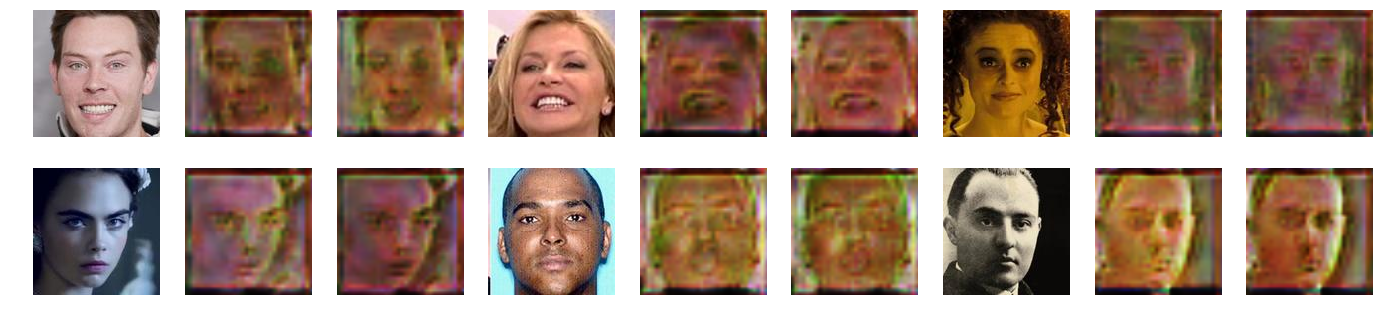

Epoch 2/1000
10000/10000 [==============================] - 208s 21ms/step - loss: 218863.7729 - KL_loss: 8.1012 - recon_loss: 218604.5336 - val_loss: 261438.1460 - val_KL_loss: 10.5194 - val_recon_loss: 261101.5240


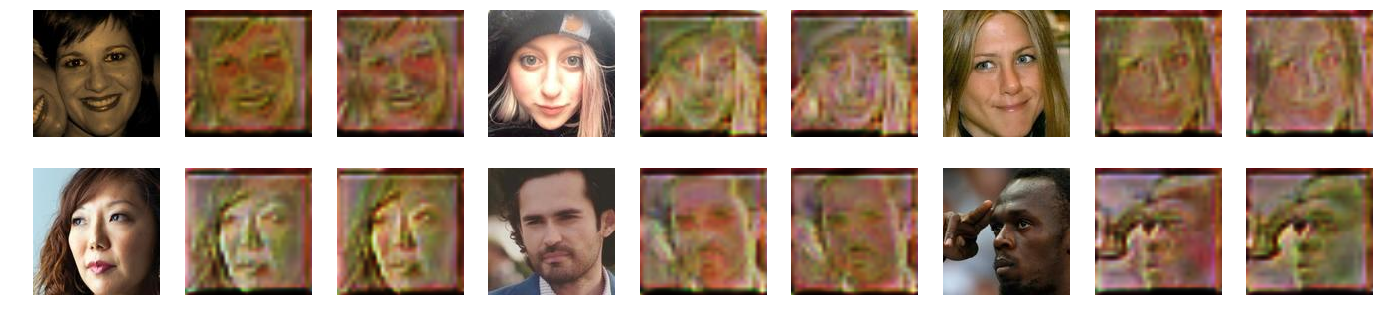

Epoch 3/1000
 3936/10000 [==========>...................] - ETA: 2:01 - loss: 217354.8464 - KL_loss: 6.6472 - recon_loss: 217142.1373

In [ ]:
# compile and fit
cvae_hist = cvae.fit(
    X, y,
    verbose=1,
    batch_size=16,
    epochs=1000,
    validation_data=(V, v),
    callbacks=[
        EarlyStopping(patience=5),
        ShowSample(),
    ],
)

TODO:

* сверточная сеть
* добавить тот крутой маленький датасет
* GAN+VAE